<a href="https://colab.research.google.com/github/Mainakdeb/project-jurkat/blob/main/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://data.broadinstitute.org/bbbc/BBBC048/BBBC048v1.zip
!wget https://data.broadinstitute.org/bbbc/BBBC048/Ground_truth.lst
!unzip "/content/BBBC048v1.zip"
!unzip "/content/CellCycle.zip"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r /content/drive/MyDrive/models/base_transfer/model_0_ws.pth /content/model_0.pth
!cp -r /content/drive/MyDrive/models/base_transfer/model_1_ws.pth /content/model_1.pth
!cp -r /content/drive/MyDrive/models/base_transfer/model_2_ws.pth /content/model_2.pth
!cp -r /content/drive/MyDrive/models/base_transfer/model_3_ws.pth /content/model_3.pth
!cp -r /content/drive/MyDrive/models/base_transfer/model_4_ws.pth /content/model_4.pth
!cp -r /content/drive/MyDrive/models/base_transfer/model_5_ws.pth /content/model_5.pth
!cp -r /content/drive/MyDrive/models/base_transfer/model_6_ws.pth /content/model_6.pth
!cp -r /content/drive/MyDrive/models/base_transfer/model_7_ws.pth /content/model_7.pth
!cp -r /content/drive/MyDrive/models/base_transfer/model_8_ws.pth /content/model_8.pth
!cp -r /content/drive/MyDrive/models/base_transfer/model_9_ws.pth /content/model_9.pth

In [4]:
!cp /content/drive/MyDrive/mydata/Jurkat_cells/cell_merged_drive_backup.csv /content/cell_merged.csv

In [5]:
#@title Import Libraries
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from albumentations import *
import torchvision.transforms as transforms
from tqdm.notebook import tnrange, tqdm
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models 
import torch.nn as nn
import time
import seaborn as sns
import os, csv
from IPython.display import clear_output

In [6]:
#@title Custom Dataset class and related utils - click to view code
def image_to_nparray(path):
    i = cv2.imread(path)
    i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    return(np.array(i))

class C_Dataset(Dataset):
    """custom"""

    def __init__(self, csv, root_dir='',augmentation=None, transform=None):
        
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.transform = transform
        self.root_dir = root_dir
        self.d = csv
        self.augmentation = augmentation
        self.class_dict = {'G1':0,
                           'S': 1,
                           'G2':2}
        
    def __getitem__(self, idx): 

        smol_img_path = str(self.d.iloc[idx][1]) #image path column
        class_name = str(self.d.iloc[idx][2])  #class name column
        full_img_path = self.root_dir + smol_img_path #+ '.png'
        img_arr = image_to_nparray(full_img_path)

        if self.augmentation is not None:
            img  = self.augmentation(image = img_arr)
            img2 = img["image"]

        if self.transform is not None:
            img_ret = self.transform(img2)
        
        return {"x": img_ret,
                "y": torch.tensor(self.class_dict[str(class_name)])
        }

    def __len__(self):
        return (len(self.d))

In [15]:
#@title Define create_subset() - click to view code
def create_subset(input_csv_path, output_csv_path, lower_lim, upper_lim):
  #create a subset
  df = pd.read_csv(input_csv_path)
  df = df.sample(frac=1)
  # iloc[row slicing, column slicing]
  subset_df = df.iloc[lower_lim:upper_lim, 1:]
  subset_df.to_csv(output_csv_path)

In [16]:
#@title Define visualize_preds() - click to view code
def visualize_preds(model, list_models, num_models, data_loader):
    fig, ax = plt.subplots(3,3, figsize = (15,15))
    torch.cuda.empty_cache()
    class_dict={'G1':0,
                'S': 1,
                'G2':2}
    available_models=list_models[0:num_models]

    for i in range (9):
        data = next(iter(data_loader))
        image, label = data['x'], data['y'].to(device)
        #print(label)
        #image[0]=np.clip(image[0], 0, 1)
        ax.flat[i].imshow(image[0].permute(1,2,0))
        batch_output= model_jury(model, available_models,image.to(device))
            
        _,batch_prediction=torch.max(batch_output.data, 1)
        image_pred=batch_prediction[0].item()
    
        text = "label: "+list(class_dict.keys())[int(label[0])] +" prediction: "+list(class_dict.keys())[int(image_pred)]
        ax.flat[i].set_xlabel(text)
        

In [28]:
#@title Define plot_confusion_matrix() - click to view code
def plot_confusion_matrix(model, list_models, num_models, data_loader):
    class_names =  ['G1', 'S', 'G2']
    confusion_matrix = torch.zeros(len(class_names), len(class_names))
    available_models=list_models[0:num_models]

    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data['x'].to(device), data['y'].to(device)
            outputs = model_jury(model, available_models,images)
            #outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for t, p in zip(labels.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    cm = confusion_matrix.numpy()
    fig = plt.figure(figsize=(6.5,6),  dpi = 80)
    ax = sns.heatmap(cm,
                    annot=True, 
                    cmap='Blues', 
                    xticklabels = class_names, 
                    yticklabels = class_names, 
                    fmt='g')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    total_correct=np.trace(cm)
    total=np.sum(cm)
    print("accuracy on hold out set: {:.3f}".format(100*total_correct/total), "%")

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [30]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(num_ftrs, 3))
model = model_ft.to(device)

In [31]:
model_paths=[]
for i in range(10):
    model_paths.append("./model_" + str(i) + ".pth")
model_paths

def model_jury(model, models_list, images):
  preds=[]
  for path in models_list:
    model.load_state_dict(torch.load(path))
    model=model.eval()
    pred=model(images).detach().cpu().numpy()
    preds.append(pred)
  return(torch.from_numpy(np.mean(preds, axis=0)))

In [32]:
create_subset(input_csv_path="/content/cell_merged.csv",
              output_csv_path="cell_merged_hold_out.csv",
              lower_lim=29000,
              upper_lim=31503)

data_holdout = C_Dataset(pd.read_csv('/content/cell_merged_hold_out.csv'), 
                 '',
                 augmentation = Compose([ 
                                        #RandomBrightnessContrast( p=0.9),
                                        #Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                #transforms.Resize((128,128)),
                                                transforms.CenterCrop((32,32)),
                                                transforms.ToTensor()
                                                ])
)

dl_holdout = torch.utils.data.DataLoader(data_holdout,
                                         batch_size=128,
                                         shuffle=True
                                        )

## Plot test images with corresponding labels and predictions:

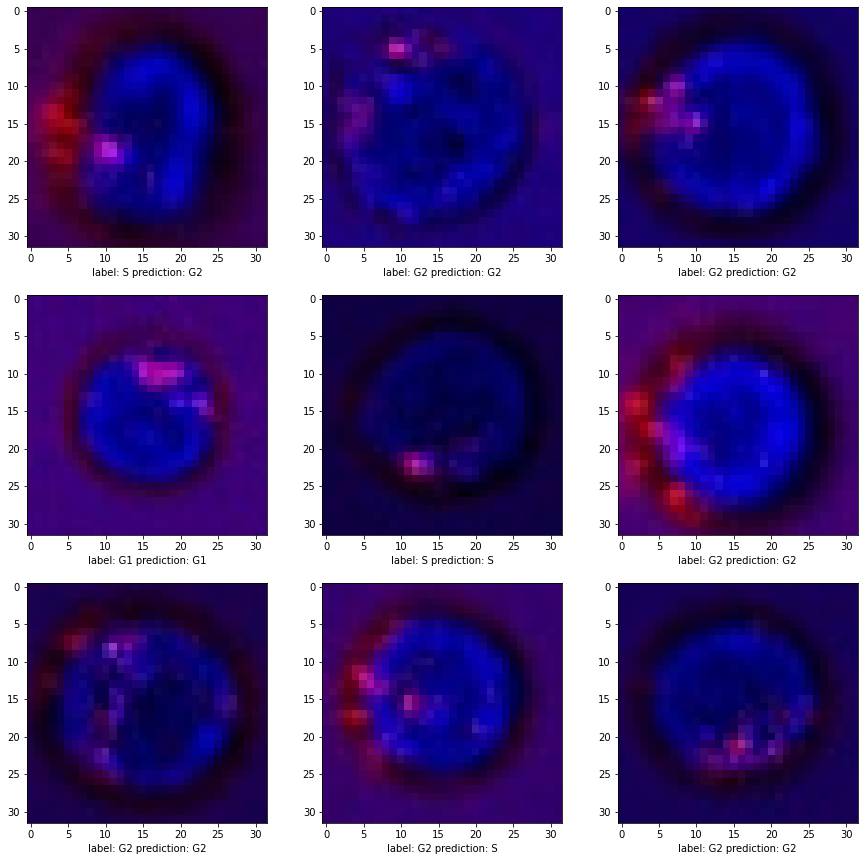

In [33]:
visualize_preds(model, list_models=model_paths, num_models=10, data_loader=dl_holdout)

## Benchmark 10 models trained on seperate training folds:


accuracy on hold out set: 88.094 %


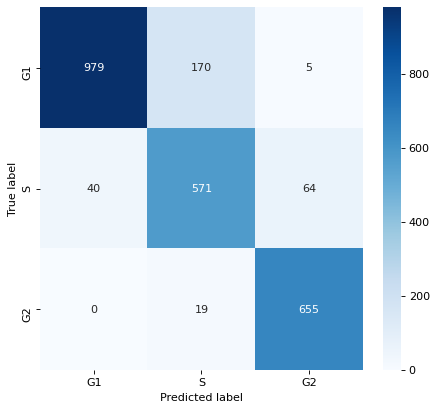

In [34]:
plot_confusion_matrix(model.to(device), list_models=model_paths, num_models=10, data_loader=dl_holdout)

The accuracy on the hold out set turns out to be 88.094%%
***

## How does only one model perform?

accuracy on hold out set: 85.577 %


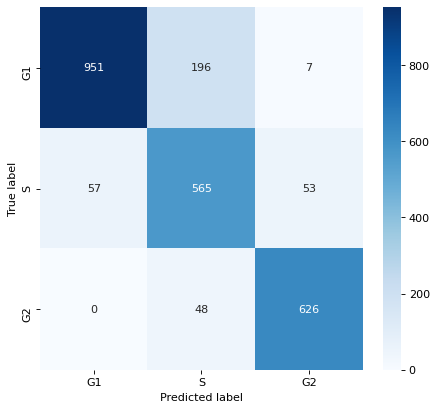

In [35]:
plot_confusion_matrix(model.to(device), list_models=model_paths, num_models=1, data_loader=dl_holdout)

The accuracy on the hold out set turns out to be 85.577%, which is worse compared to the pervious results
***

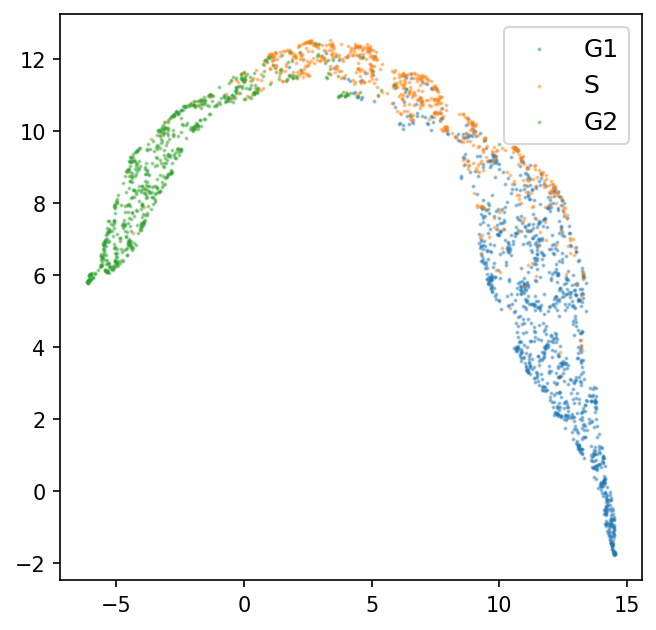

In [36]:
#@title Dimensionality Reduction (UMAP) - click to view code
!pip install tsne
import tsne
from tsne import bh_sne
 
model.cpu()
model.eval()
tsne_dir = "/content/"

out_label, out_data, out_output = [], [], []

for batch in dl_holdout: 
  data, target=batch['x'], batch['y']
  # Get predictions on the validation data 
  output = model(data)

  # Convert data to numpy and append to list
  output_np = output.data.cpu().numpy()
  label_np = target.data.cpu().numpy()
  data_np = data.data.cpu().numpy()
  
  out_output.append(output_np)
  out_label.append(label_np[:, np.newaxis])
  out_data.append(np.squeeze(data_np))

  output_array = np.concatenate(out_output, axis=0)
  label_array  = np.concatenate(out_label, axis=0)
  data_array   = np.concatenate(out_data, axis=0)

#!pip install umap-learn
import umap 

# Get UMAP predictions
reducer = umap.UMAP(n_neighbors = 200, n_components = 2, metric = 'minkowski')
embedding = reducer.fit_transform(output_array.astype(np.float64))

# Transform UMAP predictions into dataframes for visualization
names = np.unique(label_array)
umap_output_df = pd.DataFrame(embedding)
label_df = pd.DataFrame(label_array)
dataset = pd.concat([umap_output_df, label_df],axis=1)

# Get labels for class keys
label_dic = {'G1':0,'S': 1,'G2':2}
label_dic = {value:key for key, value in label_dic.items()}

# Visualize UMAP predictions
plt.figure(figsize =(5,5),  dpi = 150)
for i in range(len(np.unique(label_array))):
  data = dataset[dataset.iloc[:,2] == i]
  plt.scatter(data.iloc[:,0], data.iloc[:,1],  alpha=0.4, label =label_dic.get(i), marker= 'o', s = 0.8)
plt.legend(fontsize=12)
plt.savefig(os.path.join(tsne_dir, 'UMAP_3classes.png'), bbox_inches='tight')
plt.show()

## Outcome
Each individual point represents a data-point from the test dataset. In the above plot they are arranged according to the predictions made by the model(s).

## Results
At no point during the training process was the ordering of three interphase stages explicitly or implicitly specified. At no point did we say that S was the intermediate phase and that cells transition from G1 to G2 via S phase.

The ability of the model to arrive at this ordering of stages by learning gradual variations in size is an immensely significant result for biological systems. Imagine not knowing the actual ordering of cell cycle stages and being able to reconstruct them simply by training a model.